In [1]:
import numpy as np
%matplotlib notebook

import matplotlib.pyplot as plt
import csv
from collections import Counter, defaultdict
from matplotlib.pyplot import cm
import math

# Can change this to ./data/acl-mainconfs-from2010.csv when we've settled on which statistical tests to run
DATAFILE="./data/acl-evenyears.csv"

In [2]:
def parse_csv(filename, age_limit=None):
    '''
    A custom CSV parsing function to process the data in the Marcel format
    
    TODO: Make it possible to store the citations of each conference in their own data structure
    '''
    counters = defaultdict(Counter)  # We store the counts of publications in a dictionary, one per conference year
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')

        for row in reader:
            paper_id = row[0]
            year = int(row[1])
            citations = row[2].split(',')
            if len(citations) <= 1:
                # Front matter or articles that otherwise failed to parse any citations
                continue
            citations = [int(x) for x in citations]
            ages = [year - x for x in citations]

            for a in ages:
                if age_limit == None:
                    counters[year][a] += 1
                elif a < 0:
                    # Don't plot citations of papers that will be published in the future
                    continue
                elif abs(a) <= age_limit:
                    counters[year][a] += 1
    return counters

In [3]:
def mulitple_plots(counters):
    '''
    Create one plot for each year in the citation Counter object
    '''
    fig, axs = plt.subplots(len(counters))
    i = 0
    color = iter(cm.rainbow(np.linspace(0,1,len(counters))))
    for c in counters:
        this_color = next(color)
        sorted_counter = sorted(counters[c].items(), key=lambda pair: pair[0])
        x = [x[0] for x in sorted_counter]
        y = [x[1] for x in sorted_counter]
        sumy = sum(y)
        y = [q/sumy for q in y]  # normalise
        axs[i].plot(x, y, label=c, color=this_color)
        axs[i].legend(loc='upper right')
        i += 1

    plt.xlabel('Age = Published Year -  Citation year')
    
def single_plot(counters):
    '''
    Create a single plot that puts the data for all years onto a single plot
    '''
    fig, axs = plt.subplots(1)
    color = iter(cm.rainbow(np.linspace(0,1,len(counters))))
    for c in counters:
        this_color = next(color)
        sorted_counter = sorted(counters[c].items(), key=lambda pair: pair[0])
        x = [x[0] for x in sorted_counter]
        y = [x[1] for x in sorted_counter]
        sumy = sum(y)
        y = [q/sumy for q in y]  # normalise
        axs.plot(x, y, label=c, color=this_color)
    axs.legend(loc='upper right')
    plt.xlabel('Age = Published Year -  Citation year')

<IPython.core.display.Javascript object>


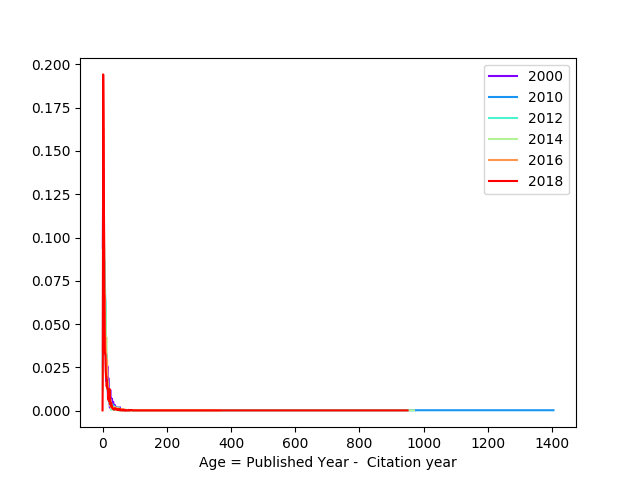

In [4]:
counters = parse_csv(DATAFILE)
single_plot(counters)

<IPython.core.display.Javascript object>


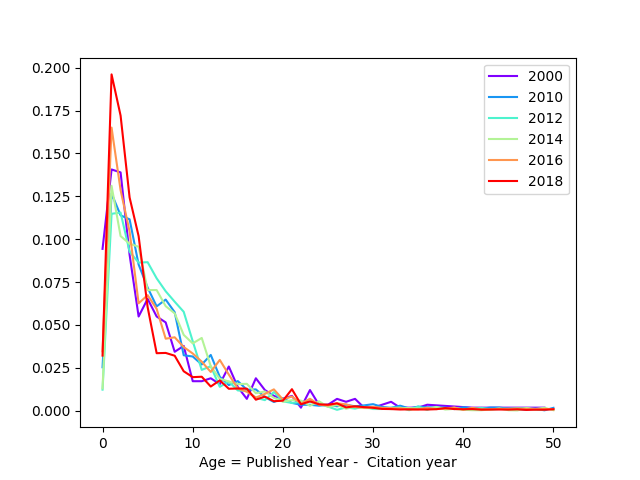

In [5]:
fifty_year_counters = parse_csv(DATAFILE, age_limit=50)
single_plot(fifty_year_counters)

# Exploring the small "ACL in even years" dataset

Let's restrict ourselves to citations from the last 50 years, as the curves are pretty much flat after that.  Also, while working on the small "ACL in even years" dataset, let's take out the year 2000 as it is less reliable and creates a large gap between it and the remaining years.

I'm also using Pandas and Seaborn from here on, so more definitions follow.

In [6]:
import pandas
import seaborn as sns
sns.set()

def parse_csv_to_pandas(filename, age_limit=None):
    '''
    A custom CSV parsing function to process the data in the Marcel format
    
    TODO: Make it possible to store the citations of each conference in their own data structure
    '''
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        df = defaultdict(list)
        
        for row in reader:
            paper_id = row[0]
            paper_venue = paper_id[0]
            year = int(row[1])
            citations = row[2].split(',')
            if len(citations) <= 1:
                # Front matter or articles that otherwise failed to parse any citations
                continue
            citations = [int(x) for x in citations]
            ages = [year - x for x in citations if x <= year]

            for a in ages:
                if age_limit is not None and abs(a) > age_limit:
                    continue
                df['paper_id'].append(paper_id)
                df['venue'].append(paper_venue)
                df['year'].append(year)
                df['cited_age'].append(a)
        
    return pandas.DataFrame.from_dict(df)

In [7]:
df = parse_csv_to_pandas(DATAFILE, age_limit=50)
df = df[df['year'] != 2000]

<IPython.core.display.Javascript object>


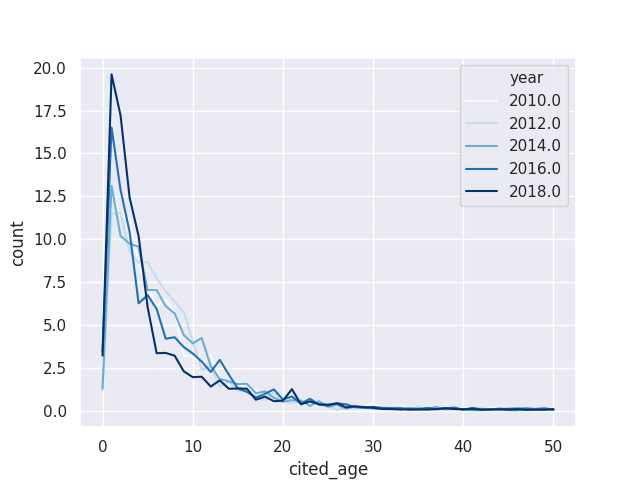

In [122]:
counts = df.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"

# normalize by total no. of citations in year
nfactor = df.groupby(['year']).count().reset_index()
counts['count'] = counts['count'].astype(float)
ncounts = counts.apply(lambda x: [x[0], x[1], 100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id'])], axis=1, result_type='broadcast')

sns.lineplot(data=ncounts, x='cited_age', y='count', hue='year', legend='full', palette='Blues')

## Q1: Does the age of citations change over time?

We want to look at the age of citations by year.  Let's see a box plot of this distribution, which shows the quantiles of the age data:

<IPython.core.display.Javascript object>


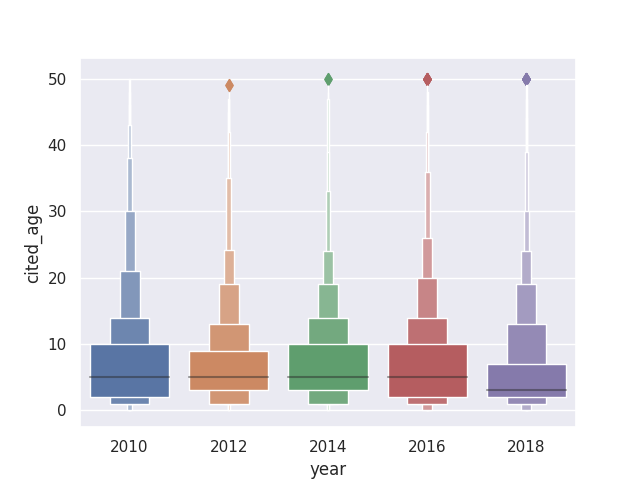

In [52]:
sns.boxenplot(data=df, x='year', y='cited_age')

The main quantile lies much lower in 2018 compared to the rest of the years, suggesting that citations are more concentrated around younger publications.

We can also see some numerical stats about the citation age:

In [60]:
import researchpy as rp
rp.summary_cont(df['cited_age'].groupby(df['year']))

,N,Mean,SD,SE,95% Conf.,Interval
year,,,,,,
2010,5575,7.471390,7.977939,0.106848,7.261948,7.680832
2012,4251,7.221360,7.125773,0.109292,7.007123,7.435596
2014,7879,7.319330,7.110760,0.080109,7.162307,7.476353
2016,9844,7.101382,7.715167,0.077761,6.948963,7.253800
2018,12244,5.960062,7.151158,0.064627,5.833388,6.086736


Wow, 2018 sure looks like an outlier here. 2016 is a bit lower than the others, but not much. Is it significant? 

### Musings about statistical testing

Let's attempt the methods [in this blog post](https://pythonfordatascience.org/anova-python/) to find out if our findings are statistically significant:

In [61]:
from statsmodels.formula.api import ols
results = ols('cited_age ~ C(year)', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cited_age   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     67.46
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           5.39e-57
Time:                        17:14:36   Log-Likelihood:            -1.3613e+05
No. Observations:               39793   AIC:                         2.723e+05
Df Residuals:                   39788   BIC:                         2.723e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.4714      0.099     75.350      0.000       7.277       7.666
C(year)[T.2012]    -0.2500      0.151     -1.659      0.097      -0.546       0.045
C(year)[T.2014]    -0.1521      0.130     -1.174      0.241      -0.406       0.102
C(year)[T.2016]    -0.3700      0.124     -2.982      0.003      -0.613      -0.127
C(year)[T.2018]    -1.5113      0.120    -12.635      0.000      -1.746      -1.277
==============================================================================
Omnibus:                    20425.656   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136629.974
Skew:                           2.434   Prob(JB):                         0.00
Kurtosis:                      10.662   Cond. No.                         7.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If I interpret this correctly, taking 2010 as the base for the comparison, the age of citations is already significantly lower in 2016 ($P_{>|t|} = 0.003$), and of course also in 2018.  However, I don't think we can use parametric tests in the first place since **the assumptions of these tests are violated.**  Most importantly, the age of citations is very obviously not normally distributed.

I think the appropriate test to check for differences between the groups is the [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance).  However, this one also clearly confirms that the year groups are not equal:

In [71]:
import scipy
scipy.stats.kruskal(df['cited_age'][df['year']==2010],
                    df['cited_age'][df['year']==2012],
                    df['cited_age'][df['year']==2014],
                    df['cited_age'][df['year']==2016],
                    df['cited_age'][df['year']==2018])

KruskalResult(statistic=774.5928809331778, pvalue=2.446000007059237e-166)

In [80]:
import itertools as it
for a, b in it.combinations((2010,2012,2014,2016,2018), 2):
    print("{}--{}: pvalue= {:.12f}".format(
        a, b,
        scipy.stats.mannwhitneyu(df['cited_age'][df['year']==a], df['cited_age'][df['year']==b]).pvalue))

2010--2012: pvalue= 0.029001272818
2010--2014: pvalue= 0.007232857224
2010--2016: pvalue= 0.000000193954
2010--2018: pvalue= 0.000000000000
2012--2014: pvalue= 0.345368823719
2012--2016: pvalue= 0.000000000018
2012--2018: pvalue= 0.000000000000
2014--2016: pvalue= 0.000000000000
2014--2018: pvalue= 0.000000000000
2016--2018: pvalue= 0.000000000000


Mann Whitney U shows that pretty much all pairs of years are significantly different from each other except for 2012--2014 and maybe 2010--2012 (I can't really make certain statements here since I didn't decide on a threshold beforehand...).



## Q2: What if we try to account for number of published papers in a year?

**Intuition:** Since more papers are published in recent years, there are more younger papers to cite than older ones, so naturally the number of younger citations will go up.  Can we account for this?

Now, we don't know the absolute number of papers published per year, but can we estimate it using the ACL Anthology?  Maybe using the full Anthology is not the best idea, as the figures will be skewed by the number of events that are covered in the Anthology for that year?

**Idea:** Get the number of articles published in ACL and CL, as these cover every year from 1980 onwards, and use them as a normalization factor based on the *year of the cited article*.

<IPython.core.display.Javascript object>


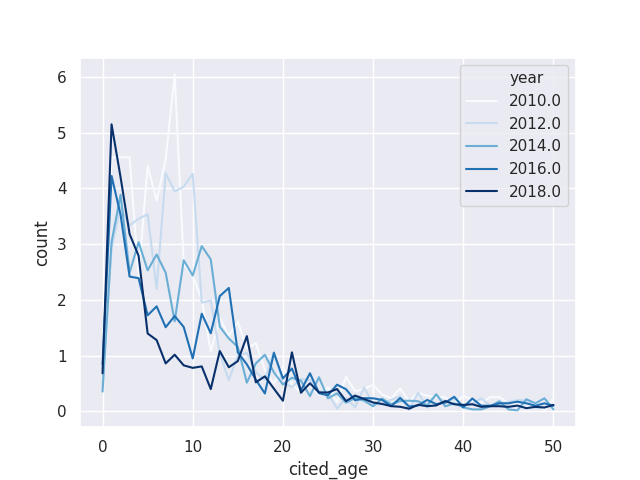

In [182]:
number_of_pubs = {}
with open("./acl_pubcount.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    number_of_pubs = {int(row[0]): int(row[1]) for row in reader}

ucounts = ncounts.apply(lambda x: [x[0], x[1], 100 * x[2] / float(number_of_pubs.get(x[0] - x[1], 70))], axis=1, result_type='broadcast')

sns.lineplot(data=ucounts, x='cited_age', y='count', hue='year', legend='full', palette='Blues')

Well, this actually seems to *amplify* the recency effect, particularly for the range of 3--10 year old papers.  However, I'm skeptical now that using the article count from the Anthology makes any sense, as the numbers are all over the place:

In [183]:
number_of_pubs

{1980: 79,
 1981: 76,
 1982: 70,
 1983: 55,
 1984: 151,
 1985: 79,
 1986: 95,
 1987: 73,
 1988: 102,
 1989: 92,
 1990: 89,
 1991: 102,
 1992: 106,
 1993: 101,
 1994: 108,
 1995: 107,
 1996: 110,
 1997: 118,
 1998: 303,
 1999: 134,
 2000: 130,
 2001: 122,
 2002: 95,
 2003: 143,
 2004: 161,
 2005: 163,
 2006: 351,
 2007: 245,
 2008: 250,
 2009: 278,
 2010: 315,
 2011: 391,
 2012: 262,
 2013: 432,
 2014: 365,
 2015: 391,
 2016: 410,
 2017: 381,
 2018: 470}

## Q3: Are older papers cited less than before?

The plots for Q1 suggested that older papers are cited less in terms of proportions, but that doesn't mean older literature is increasingly ignored: if citation rates for younger papers went up, but stayed the same for older papers, that could also explain this effect. 

<IPython.core.display.Javascript object>


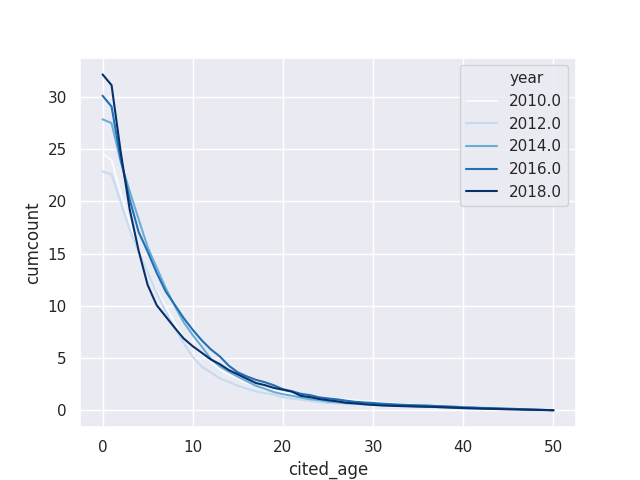

In [184]:
# normalize by total no. of *papers* in year
pfactor = df['paper_id'].groupby(df['year']).nunique('paper_id').reset_index()
counts['count'] = counts['count'].astype(float)
pcounts = counts.apply(lambda x: [x[0], x[1], x[2] / float(pfactor[pfactor['year']==x[0]]['paper_id'])], axis=1, result_type='broadcast')

# cumulative count of citations of age X or older
# need to reverse first so we start from the oldest...
pcounts = pcounts.sort_values(by='cited_age', ascending=False)
# then cumulatively sum up, for each year individually
pcounts['cumcount'] = pcounts.groupby('year')['count'].transform(pandas.Series.cumsum)

sns.lineplot(data=pcounts, x='cited_age', y='cumcount', hue='year', legend='full', palette='Blues')

The graph above shows the **average number of citations per paper that are *X* or more years old**.

At point 0, it shows the average number of cited publications per paper. We can see that in more recent years, papers tend to cite more papers on average. *(NB: We could calculate this value more easily from the parsed citation files directly, and crosscheck that way that the calculations leading up to this graph are correct...)*

Considering "older" citations, say, citations for papers that are at least 10 years old, the trend is that they are of course cited way less often, but **there doesn't appear to be a clear trend based on publication year**, giving evidence *against* a "recency effect".

This can be seen more easily when zooming in on the older citations:

<IPython.core.display.Javascript object>


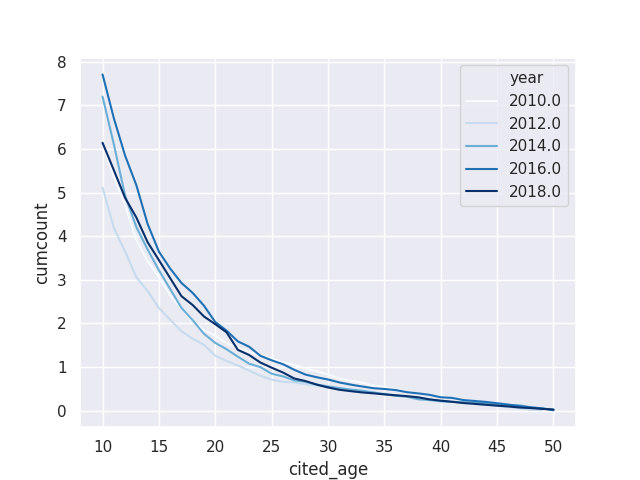

In [185]:
sns.lineplot(data=pcounts[pcounts['cited_age']>=10], x='cited_age', y='cumcount', hue='year', legend='full', palette='Blues')